## Dependencies and Settings

In [115]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random
import itertools as it
import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

por_temp_str = "dados_para_correlacoes_juntos_por_temp.csv"
juntos_str = "dados_para_correlacoes_juntos_.csv"

## Metrics

In [116]:
class Metric(object):
    
    
    @staticmethod
    def uni(x, y, att):
        return abs(x[att] - y[att])

    
    @staticmethod
    def cuttoff(weight, c):
        return weight >= c

    
    @staticmethod
    def significants(x=None, y=None, msf=None, show=False, **kwargs):
        tempx, tempy = x['temperamento'], y['temperamento']
        
        abs_negative = Metric.uni(x,y, 'qtd_posts_negativos')
        abs_emoticon = Metric.uni(x,y, 'qtd_posts_possui_emoticon')
        abs_neutral = Metric.uni(x,y, 'qtd_posts_neutros')

        stdx, stdy = msf['qtd_posts_negativos'].at[tempx, 'std'], msf['qtd_posts_negativos'].at[tempy, 'std']
        ux, uy = msf['qtd_posts_negativos'].at[tempx, 'mean'], msf['qtd_posts_negativos'].at[tempy, 'mean']
        abs_std_negative = abs(stdx - stdy) if tempx != tempy else 1
        abs_std_negative = 1
        abs_mean_negative = abs(ux - uy) if tempx != tempy else 1
        rel_negative1 = abs_negative / abs_std_negative # "relative1" value for negative metric
        rel_negative2 = abs_negative / (abs_std_negative*abs_std_negative) # "relative2" value for negative metric
        rel_negative3 = abs_negative / abs_mean_negative # "relative3" value for negative metric
        
        stdx, stdy = msf['qtd_posts_possui_emoticon'].at[tempx, 'std'], msf['qtd_posts_possui_emoticon'].at[tempy, 'std']
        ux, uy = msf['qtd_posts_possui_emoticon'].at[tempx, 'mean'], msf['qtd_posts_possui_emoticon'].at[tempy, 'mean']
        abs_std_emoticon = abs(stdx - stdy) if tempx != tempy else 1
        abs_mean_emoticon = abs(ux - uy) if tempx != tempy else 1
        rel_emoticon1 = abs_emoticon / abs_std_emoticon # "relative1" value for emoticon metric
        rel_emoticon2 = abs_emoticon / (abs_std_emoticon*abs_mean_emoticon) # "relative2" value for emoticon metric
        rel_emoticon3 = abs_emoticon / abs_mean_emoticon # "relative3" value for emoticon metric

        stdx, stdy = msf['qtd_posts_neutros'].at[tempx, 'std'], msf['qtd_posts_neutros'].at[tempy, 'std']
        ux, uy = msf['qtd_posts_neutros'].at[tempx, 'mean'], msf['qtd_posts_neutros'].at[tempy, 'mean']
        abs_std_neutral = abs(stdx - stdy) if tempx != tempy else 1
        abs_mean_neutral = abs(ux - uy) if tempx != tempy else 1
        rel_neutral1 = abs_neutral / abs_std_neutral # "relative1" value for neutral metric
        rel_neutral2 = abs_neutral / (abs_std_neutral*abs_mean_neutral) # "relative2" value for neutral metric
        rel_neutral3 = abs_neutral / abs_mean_neutral # "relative3" value for neutral metric

        if show:
            print(f"{tempx}=={tempy}={tempx==tempy}      |f_neg_x - f_neg_y|={abs_negative}      |f_emo_x - f_emo_y|={abs_emoticon}      |f_neu_x - f_neu_y|={abs_neutral}      ", end='')
            print(f"{tempx}=={tempy}={tempx==tempy}      |std_neg_x - std_neg_y|={abs_std_negative}      |std_emo_x - std_emo_y|={abs_std_emoticon}      |std_neu_x - std_neu_y|={abs_std_neutral}      ", end='')
            print(f"{tempx}=={tempy}={tempx==tempy}      |u_neg_x - u_neg_y|={abs_mean_negative}      |u_emo_x - u_emo_y|={abs_mean_emoticon}      |u_neu_x - u_neu_y|={abs_mean_neutral}      ", end='')
            print()
            print()

        a1, a2, a3 = kwargs['a1'], kwargs['a2'], kwargs['a3']
        b1, b2, b3 = kwargs['b1'], kwargs['b2'], kwargs['b3']
        c1, c2, c3 = kwargs['c1'], kwargs['c2'], kwargs['c3']

        return a1*rel_negative1 + b1*rel_emoticon1 + c1*rel_neutral1 + a2*rel_negative2 + b2*rel_emoticon2 + c2*rel_neutral2 + a3*rel_negative3 + b3*rel_emoticon3 + c3*rel_neutral3
        

## Utils

In [117]:
def prepare_data(apply_filter=True, std=3):
    users = pd.read_csv("dados_para_correlacoes_juntos_por_temp.csv")
    users.user_id.astype(int)
    grouped = users.groupby('user_id')
    
    exclude_column = 'temperamento'
    agg_dict = {col: lambda series: series.iloc[0] for col in users.columns if col != exclude_column}
    agg_dict.pop('user_id')
    # print(agg_dict)
    agg_dict['temperamento'] = lambda series: ','.join(series)
    
    users_ = grouped.agg(agg_dict).reset_index()
    
    def first_temp(ts):
        ts = ts.split(',')
        temp = ''
        for t in ts:
            temp += str(t[0])
    
        return temp
    
    users_.temperamento = users_.temperamento.apply(first_temp)
    
    # to filter all outliers
    if apply_filter:
        temperamento = users_.temperamento.copy()
        users_ = users_[(np.abs(stats.zscore(users_.drop(labels=['temperamento'], axis=1))) < std).all(axis=1)]
        users_['temperamento'] = temperamento
    
    # users_ = users_[users_['user_id'] != 1027] # to filter outlier user_id=1027
    
    users_.to_csv('dados_para_correlacoes_juntos_.csv', index=False)
    return users_

In [118]:
# metrics=['count', 'mean', 'std']
def metrics_stratified_filtered(users, metrics=None):
    if metrics is None:
        return users.groupby('temperamento').describe()
    else:
        return users.groupby('temperamento').describe().loc[:, (slice(None), metrics)]

In [119]:
def calculate_if_var_significant(metric, temp1, temp2, msf=None, alpha=0.05, filter_for_significant=False, print_res=True):   
    # Sample data (standard deviations and sample sizes)
    s1 = msf[metric].at[temp1, 'std']  # Standard deviation of sample 1
    s2 = msf[metric].at[temp2, 'std']  # Standard deviation of sample 2
    n1 = msf[metric].at[temp1, 'count']  # Sample size of sample 1
    n2 = msf[metric].at[temp1, 'count']  # Sample size of sample 2

    if n1 == 1 or n2 == 1 or s1 == 0 or s2 == 0 or math.isnan(s1) or math.isnan(s2):
        return None
    
    # Variance calculation
    var1 = s1 ** 2
    var2 = s2 ** 2

    print(metric, temp1, var1, s1, temp2, var2, s2)
    
    # F-statistic calculation

    F = var1 / var2
    
    # Degrees of freedom
    df1 = n1 - 1
    df2 = n2 - 1
    
    # P-value calculation
    p_value = 2 * min(f.cdf(F, df1, df2), 1 - f.cdf(F, df1, df2))
    
    # Interpret the result
    if p_value < alpha:
        if print_res:
            print(f'F-statistic: {F}')
            print(f'P-value: {p_value}')
            print(f"Reject the null hypothesis: The variances for '{metric}' found for '{temp1}' and '{temp2}' are significantly different.")
        return (metric, temp1, temp2, p_value, alpha)
    elif not filter_for_significant:
        if print_res:
            print(f'F-statistic: {F}')
            print(f'P-value: {p_value}')
            print(f"Fail to reject the null hypothesis: The variances for '{metric}' found for '{temp1}' and '{temp2}' are NOT significantly different.")
        return (metric, temp1, temp2, p_value, alpha)

In [120]:
def calc_all_var_significants(users, **kwargs):
    metrics = list(filter(lambda e: e not in ['user_id', 'temperamento'], users.columns))
    temps = list(filter(lambda x: x[0]<x[1], it.combinations(users['temperamento'].unique(), 2)))
    msf = metrics_stratified_filtered(users)
    alpha = kwargs['alpha']
    
    rs = []
    
    for metric in metrics:
        for temp1, temp2 in temps:
            try:
                r = calculate_if_var_significant(metric, temp1, temp2, msf, alpha, filter_for_significant=False, print_res=True)
            except:
                r = None
            if r is not None:
                (metric, temp1, temp2, p_value, alpha) = r
                rs.append((metric, temp1, temp2, p_value))

    return rs

In [121]:
def draw_distributions(temp1, temp2, metric=None, msf=None, size=10000, color1='blue', color2='orange'):

    # Define mean and standard deviation for the distributions
    mean1, std1 = msf[metric].at[temp1, 'mean'], msf[metric].at[temp1, 'std']  # Distribution 1
    mean2, std2 = msf[metric].at[temp2, 'mean'], msf[metric].at[temp2, 'std']  # Distribution 2
    
    # Generate data for the distributions
    data1 = np.random.normal(loc=mean1, scale=std1, size=size)
    data2 = np.random.normal(loc=mean2, scale=std2, size=size)
    
    # Create a Seaborn plot
    sns.histplot(data=data1, kde=True, color=color1, label=temp1, fill=False, element="step")
    sns.histplot(data=data2, kde=True, color=color2, label=temp2, fill=False, element="step")
    
    # Add labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f"Two Normal Distributions For '{metric}'")

    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()

In [187]:
def create_graph_from_metric(users, metric=Metric.significants, **kwargs):
    G = nx.Graph()
    msf = metrics_stratified_filtered(users)
    
    for i, di in users.iterrows():
        idi = str(di['user_id']) + '-' + di['temperamento']
        G.add_node(idi, user_id=di['user_id'], temperamento=di['temperamento'])
        
        for j, dj in users.iterrows():
            if j > i:
                weight = metric(x=di, y=dj, msf=msf, **kwargs)
            
            if j > i and weight > 0:    
                idj = str(dj['user_id']) + '-' + dj['temperamento']
                G.add_node(idj, user_id=dj['user_id'], temperamento=dj['temperamento'])
                G.add_edge(idi, idj, weight=weight)

    return G

In [408]:
def create_graph_from_communities(users, communities, metric=Metric.significants, **kwargs):
    G = nx.Graph()
    msf = metrics_stratified_filtered(users)
    
    for i, di in users.iterrows():
        idi = str(di['user_id']) + '-' + di['temperamento']
        # G.add_node(idi, user_id=di['user_id'], temperamento=di['temperamento'])
        
        for j, dj in users.iterrows():
            if j > i:
                weight = metric(x=di, y=dj, msf=msf, **kwargs)

            idj = str(dj['user_id']) + '-' + dj['temperamento']
            mask = list(map(lambda community: idi in community and idj in community, communities))
            
            if j > i and weight > 0 and any(mask):
                new_id_community = str(mask.index(True))
                # new_id_community = communities_labels[mask.index(True)]
                idi = str(di['user_id']) + '-' + di['temperamento']
                G.add_node(idi, user_id=di['user_id'], temperamento=di['temperamento'], community=new_id_community)
                idj = str(dj['user_id']) + '-' + dj['temperamento']
                G.add_node(idj, user_id=dj['user_id'],  temperamento=dj['temperamento'], community=new_id_community)
                G.add_edge(idi, idj, weight=weight)

    return G

In [241]:
def draw_graph(G,
               color_map={'d': 'tab:red',
                          'acdhiw': 'tab:green',
                          'cd': 'tab:blue',
                          'i': 'tab:orange',
                          'cdi': 'tab:purple',
                          'di': 'tab:pink',
                          'ad': 'tab:red',
                          'hi': 'tab:green',
                          'dh': 'tab:blue',
                          'c': 'tab:orange'},
               max_dir=5,
               color_map_dir={'d': (1,1),
                              'acdhiw': (1,-1),
                              'cd': (-1,1),
                              'i': (-1,-1),
                              'cdi': (1,1),
                              'di': (1,-1),
                              'ad': (-1,1),
                              'hi': (-1,-1),
                              'dh': (1,1),
                              'c': (1,-1)},
              options = {"edgecolors": "tab:gray", "node_size": 400, "alpha": 0.9},
              pos_override=None,
              target="temperamento"):

    random.seed(42)

    # nodes
    # pos_override = nx.spring_layout(G, seed=252346)  # positions for all nodes
    pos = {}
    
    temperamentos = list(color_map.keys())
    
    for temperamento in temperamentos:
        nodelist = list(filter(lambda node: G.nodes()[node][target] == temperamento, list(G.nodes())))
        for node in nodelist:
            drctn = color_map_dir[temperamento]
            dir_x = drctn[0]
            dir_y = drctn[1]
            rand_x = random.uniform(0, max_dir)
            rand_y = random.uniform(0, max_dir)
            # print(dir_x * rand_x, dir_y * rand_y)
            pos.update({node: (dir_x * rand_x, dir_y * rand_y)})

        if pos_override is not None:
            pos = pos_override
        
        nx.draw_networkx_nodes(G, pos,
                               nodelist=nodelist,
                               node_color=color_map[temperamento],
                               label=temperamento,
                               **options)

    if pos_override is not None:
        pos = pos_override
    
    # edges
    nx.draw_networkx_edges(G, pos,
                           edgelist=G.edges(),
                           width=0.5,
                           alpha=0.2,
                           edge_color="tab:gray")
    
    
    plt.tight_layout()
    plt.axis("on")
    plt.show()

In [253]:
def calc_modularity(G, communities={'d', 'acdhiw', 'cd', 'i', 'cdi', 'di', 'ad', 'hi', 'dh', 'c'}, target='temperamento'):   
    aux = dict()
    for c in communities:
        aux.update({c: []})
    communities = aux
    
    for n, dn in G.nodes(data=True):
        communities[dn[target]].append(n)
    
    communities = list(map(lambda e: set(e), communities.values()))
    
    return nx.community.modularity(G, communities)

In [ ]:
def infer_communities_from_node_data(G, target="temperamento"):
    return set(dict(G_significants_louvain.nodes.data(target)).values())

In [272]:
def get_grouped_temperaments_from_partition(partition):
    return list(map(lambda community: set(map(lambda node: node.split('-')[1], community)), partition))

def get_labels_for_grouped(communities):
    l = lambda x: str(x).replace("\'", "").replace(",", "").replace("{", "").replace("}", "").replace(" ", "-")
    return list(map(l, grouped))

## Analysing and Describing Dataset

In [128]:
# users = pd.read_csv(por_temp_str)

prepare_data(apply_filter=True, std=5)
users = pd.read_csv(juntos_str)

In [129]:
users.shape

(88, 16)

In [130]:
users

,user_id,qtd_posts,media_likes,qtd_posts_positivos,qtd_posts_negativos,qtd_posts_neutros,qtd_posts_possui_emoticon,seguidores,seguidos,proporcao_final_semana,proporcao_meio_semana,proporcao_manha,proporcao_tarde,proporcao_noite,proporcao_madrugada,temperamento
0,8,7,176.142857,6,0,1,7,1220,1108,0.428600,0.571400,0.142900,0.428600,0.428600,0.000000,ad
1,10,5,9.000000,3,0,2,2,49,60,0.200000,0.800000,0.200000,0.400000,0.200000,0.200000,acdhiw
2,12,2,60.500000,2,0,0,1,161,279,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,cdi
3,13,3,108.666667,3,0,0,2,392,901,0.333300,0.666700,0.000000,0.666700,0.333300,0.000000,d
4,14,21,61.857143,15,0,6,12,529,599,0.476200,0.523800,0.238100,0.333300,0.381000,0.047600,cd
5,15,14,95.142857,9,1,4,14,601,369,0.500000,0.500000,0.285700,0.571400,0.142900,0.000000,d
6,16,12,125.833333,12,0,0,7,999,962,0.500000,0.500000,0.250000,0.416700,0.333300,0.000000,d
7,17,5,122.600000,5,0,0,5,1076,1218,0.200000,0.800000,0.000000,0.400000,0.600000,0.000000,d
8,19,20,37.550000,16,1,3,14,236,376,0.600000,0.400000,0.050000,0.550000,0.350000,0.050000,di
9,21,7,114.142857,4,2,1,0,544,379,0.428600,0.571400,0.428600,0.142900,0.428600,0.000000,d


In [131]:
original = pd.read_csv('dados_para_correlacoes_juntos.csv')
original

,user_id,qtd_posts,media_likes,qtd_posts_positivos,qtd_posts_negativos,qtd_posts_neutros,qtd_posts_possui_emoticon,seguidores,seguidos,temperamento
0,8.000000,7.000000,176.142857,6.000000,0.000000,1.000000,7.000000,1220.000000,1108.000000,"anxious,depressive"
1,10.000000,5.000000,9.000000,3.000000,0.000000,2.000000,2.000000,49.000000,60.000000,",anxious,cyclothymic,depressive,hyperthymic,ir..."
2,12.000000,2.000000,60.500000,2.000000,0.000000,0.000000,1.000000,161.000000,279.000000,"cyclothymic,depressive,irritable"
3,13.000000,3.000000,108.666667,3.000000,0.000000,0.000000,2.000000,392.000000,901.000000,depressive
4,14.000000,21.000000,61.857143,15.000000,0.000000,6.000000,12.000000,529.000000,599.000000,"cyclothymic,depressive"
5,15.000000,14.000000,95.142857,9.000000,1.000000,4.000000,14.000000,601.000000,369.000000,depressive
6,16.000000,12.000000,125.833333,12.000000,0.000000,0.000000,7.000000,999.000000,962.000000,depressive
7,17.000000,5.000000,122.600000,5.000000,0.000000,0.000000,5.000000,1076.000000,1218.000000,depressive
8,19.000000,20.000000,37.550000,16.000000,1.000000,3.000000,14.000000,236.000000,376.000000,"depressive,irritable"
9,21.000000,7.000000,114.142857,4.000000,2.000000,1.000000,0.000000,544.000000,379.000000,depressive


In [132]:
diff = pd.merge(original, users, on='user_id', how='outer', indicator=True)
diff[diff._merge == 'left_only']

,user_id,qtd_posts_x,media_likes_x,qtd_posts_positivos_x,qtd_posts_negativos_x,qtd_posts_neutros_x,qtd_posts_possui_emoticon_x,seguidores_x,seguidos_x,temperamento_x,qtd_posts_y,media_likes_y,qtd_posts_positivos_y,qtd_posts_negativos_y,qtd_posts_neutros_y,qtd_posts_possui_emoticon_y,seguidores_y,seguidos_y,proporcao_final_semana,proporcao_meio_semana,proporcao_manha,proporcao_tarde,proporcao_noite,proporcao_madrugada,temperamento_y,_merge
11,52.000000,28.000000,405.357143,16.000000,0.000000,12.000000,8.000000,60102.000000,2002.000000,depressive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
64,1007.000000,2.000000,7.500000,1.000000,0.000000,1.000000,1.000000,141.000000,246.000000,depressive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
79,1027.000000,1834.000000,62.604144,1587.000000,0.000000,247.000000,549.000000,3898.000000,7433.000000,depressive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [133]:
metrics = users.describe()
metrics

,user_id,qtd_posts,media_likes,qtd_posts_positivos,qtd_posts_negativos,qtd_posts_neutros,qtd_posts_possui_emoticon,seguidores,seguidos,proporcao_final_semana,proporcao_meio_semana,proporcao_manha,proporcao_tarde,proporcao_noite,proporcao_madrugada
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,472.681818,21.340909,111.994909,17.272727,0.147727,3.920455,13.840909,993.988636,948.897727,0.342605,0.657395,0.140709,0.266767,0.467923,0.124599
std,422.159624,24.539383,106.220412,21.620939,0.416327,5.657304,19.725639,1013.337214,950.395841,0.186577,0.186577,0.142330,0.227174,0.253091,0.171506
min,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,149.500000,5.000000,44.166667,3.000000,0.000000,1.000000,1.750000,390.250000,425.000000,0.250000,0.542800,0.000000,0.112875,0.294550,0.000000
50%,240.000000,12.500000,79.620968,9.500000,0.000000,2.000000,7.000000,796.500000,687.000000,0.333300,0.666700,0.125000,0.253700,0.418050,0.046550
75%,1013.250000,24.250000,131.998206,23.000000,0.000000,5.250000,17.000000,1158.000000,1139.750000,0.457200,0.750000,0.241075,0.333300,0.649750,0.200000
max,1040.000000,106.000000,555.214286,94.000000,2.000000,46.000000,87.000000,7207.000000,6744.000000,1.000000,1.000000,0.500000,1.000000,1.000000,0.750000


In [134]:
users['temperamento'].value_counts()

temperamento
d         41
acdhiw    27
cd         6
i          4
cdi        3
di         3
ad         1
hi         1
dh         1
c          1
Name: count, dtype: int64

In [135]:
ms = metrics_stratified_filtered(users)
ms

user_id                                                 \
                 count        mean        std         min         25%   
temperamento                                                            
acdhiw       27.000000  499.370370 409.111152   10.000000  204.500000   
ad            1.000000    8.000000        NaN    8.000000    8.000000   
c             1.000000 1024.000000        NaN 1024.000000 1024.000000   
cd            6.000000  157.166667 111.129504   14.000000   62.500000   
cdi           3.000000  417.666667 519.355691   12.000000  125.000000   
d            41.000000  505.243902 444.333646   13.000000  123.000000   
dh            1.000000 1020.000000        NaN 1020.000000 1020.000000   
di            3.000000  172.000000 132.661223   19.000000  130.500000   
hi            1.000000  202.000000        NaN  202.000000  202.000000   
i             4.000000  608.000000 487.646046  115.000000  226.000000   

                                                 qtd_posts            \
                     50%         75%         max     count      mean   
temperamento                                                           
acdhiw        262.000000 1003.500000 1036.000000 27.000000 23.629630   
ad              8.000000    8.000000    8.000000  1.000000  7.000000   
c            1024.000000 1024.000000 1024.000000  1.000000 22.000000   
cd            193.000000  243.250000  264.000000  6.000000 30.833333   
cdi           238.000000  620.500000 1003.000000  3.000000 11.333333   
d             229.000000 1015.000000 1040.000000 41.000000 22.780488   
dh           1020.000000 1020.000000 1020.000000  1.000000  1.000000   
di            242.000000  248.500000  255.000000  3.000000 11.000000   
hi            202.000000  202.000000  202.000000  1.000000  1.000000   
i             640.000000 1022.000000 1037.000000  4.000000  5.750000   

                                                                           \
                   std       min       25%       50%       75%        max   
temperamento                                                                
acdhiw       26.459182  1.000000  4.500000 14.000000 27.500000 101.000000   
ad                 NaN  7.000000  7.000000  7.000000  7.000000   7.000000   
c                  NaN 22.000000 22.000000 22.000000 22.000000  22.000000   
cd           33.736726  6.000000  6.500000 14.500000 48.000000  87.000000   
cdi          10.692677  2.000000  5.500000  9.000000 16.000000  23.000000   
d            24.814826  1.000000  6.000000 14.000000 31.000000 106.000000   
dh                 NaN  1.000000  1.000000  1.000000  1.000000   1.000000   
di            9.539392  1.000000  6.500000 12.000000 16.000000  20.000000   
hi                 NaN  1.000000  1.000000  1.000000  1.000000   1.000000   
i             4.500000  2.000000  2.750000  4.500000  7.500000  12.000000   

             media_likes                                              \
                   count       mean        std        min        25%   
temperamento                                                           
acdhiw         27.000000 117.806560 129.399676   9.000000  57.797619   
ad              1.000000 176.142857        NaN 176.142857 176.142857   
c               1.000000 245.363636        NaN 245.363636 245.363636   
cd              6.000000 113.506791  57.489719  33.500000  73.684524   
cdi             3.000000  85.889694  69.383049  32.777778  46.638889   
d              41.000000 107.242078  96.775521   0.000000  32.714286   
dh              1.000000  38.000000        NaN  38.000000  38.000000   
di              3.000000 162.794444 203.837276  37.550000  45.191667   
hi              1.000000  31.000000        NaN  31.000000  31.000000   
i               4.000000  90.062500  70.422251  43.666667  54.041667   

                                              qtd_posts_positivos            \
                    50%        75%        max               count      mean   
temperamento                   

In [136]:
msf = metrics_stratified_filtered(users, metrics=['count', 'mean', 'std'])
msf

user_id                        qtd_posts                      \
                 count        mean        std     count      mean       std   
temperamento                                                                  
acdhiw       27.000000  499.370370 409.111152 27.000000 23.629630 26.459182   
ad            1.000000    8.000000        NaN  1.000000  7.000000       NaN   
c             1.000000 1024.000000        NaN  1.000000 22.000000       NaN   
cd            6.000000  157.166667 111.129504  6.000000 30.833333 33.736726   
cdi           3.000000  417.666667 519.355691  3.000000 11.333333 10.692677   
d            41.000000  505.243902 444.333646 41.000000 22.780488 24.814826   
dh            1.000000 1020.000000        NaN  1.000000  1.000000       NaN   
di            3.000000  172.000000 132.661223  3.000000 11.000000  9.539392   
hi            1.000000  202.000000        NaN  1.000000  1.000000       NaN   
i             4.000000  608.000000 487.646046  4.000000  5.750000  4.500000   

             media_likes                       qtd_posts_positivos            \
                   count       mean        std               count      mean   
temperamento                                                                   
acdhiw         27.000000 117.806560 129.399676           27.000000 19.481481   
ad              1.000000 176.142857        NaN            1.000000  6.000000   
c               1.000000 245.363636        NaN            1.000000 17.000000   
cd              6.000000 113.506791  57.489719            6.000000 26.000000   
cdi             3.000000  85.889694  69.383049            3.000000  9.000000   
d              41.000000 107.242078  96.775521           41.000000 18.317073   
dh              1.000000  38.000000        NaN            1.000000  1.000000   
di              3.000000 162.794444 203.837276            3.000000  7.333333   
hi              1.000000  31.000000        NaN            1.000000  0.000000   
i               4.000000  90.062500  70.422251            4.000000  3.500000   

                       qtd_posts_negativos                    \
                   std               count     mean      std   
temperamento                                                   
acdhiw       23.324418           27.000000 0.148148 0.362014   
ad                 NaN            1.000000 0.000000      NaN   
c                  NaN            1.000000 0.000000      NaN   
cd           32.875523            6.000000 0.166667 0.408248   
cdi           8.185353            3.000000 0.333333 0.577350   
d            21.338274           41.000000 0.146341 0.477545   
dh                 NaN            1.000000 0.000000      NaN   
di            8.082904            3.000000 0.333333 0.577350   
hi                 NaN            1.000000 0.000000      NaN   
i             4.434712            4.000000 0.000000 0.000000   

             qtd_posts_neutros                   qtd_posts_possui_emoticon  \
                         count     mean      std                     count   
temperamento                                                                 
acdhiw               27.000000 4.000000 3.980723                 27.000000   
ad                    1.000000 1.000000      NaN                  1.000000   
c                     1.000000 5.000000      NaN                  1.000000   
cd                    6.000000 4.666667 2.658320                  6.000000   
cdi                   3.000000 2.000000 2.000000                  3.000000   
d                    41.000000 4.317073 7.484781                 41.000000   
dh                    1.000000 0.000000      NaN                  1.000000   
di                    3.000000 3.333333 2.516611                  3.000000   
hi                    1.000000 1.000000      NaN                  1.000000   
i                     4.000000 2.250000 1.707825                  4.000000   

                                 seguidores                          seguidos  \
                 

In [137]:
all_sign_vars = pd.DataFrame(calc_all_var_significants(users, alpha=0.05), columns=['metric', 'temp1', 'temp2', 'p_value'])
all_sign_vars

qtd_posts acdhiw 700.088319088319 26.45918213188607 cdi 114.33333333333336 10.692676621563628
qtd_posts acdhiw 700.088319088319 26.45918213188607 d 615.7756097560975 24.814826409952932
qtd_posts acdhiw 700.088319088319 26.45918213188607 cd 1138.1666666666665 33.73672578462033
qtd_posts acdhiw 700.088319088319 26.45918213188607 di 91.0 9.539392014169456
qtd_posts acdhiw 700.088319088319 26.45918213188607 i 20.25 4.5
qtd_posts cdi 114.33333333333336 10.692676621563628 d 615.7756097560975 24.814826409952932
qtd_posts cdi 114.33333333333336 10.692676621563628 di 91.0 9.539392014169456
qtd_posts cdi 114.33333333333336 10.692676621563628 i 20.25 4.5
qtd_posts d 615.7756097560975 24.814826409952932 di 91.0 9.539392014169456
qtd_posts d 615.7756097560975 24.814826409952932 i 20.25 4.5
qtd_posts cd 1138.1666666666665 33.73672578462033 di 91.0 9.539392014169456
qtd_posts cd 1138.1666666666665 33.73672578462033 i 20.25 4.5
qtd_posts di 91.0 9.539392014169456 i 20.25 4.5
media_likes acdhiw 16744.2

,metric,temp1,temp2,p_value


In [138]:
users.query("temperamento == 'acdhiw'").sort_values(by=['media_likes'])

,user_id,qtd_posts,media_likes,qtd_posts_positivos,qtd_posts_negativos,qtd_posts_neutros,qtd_posts_possui_emoticon,seguidores,seguidos,proporcao_final_semana,proporcao_meio_semana,proporcao_manha,proporcao_tarde,proporcao_noite,proporcao_madrugada,temperamento
1,10,5,9.000000,3,0,2,2,49,60,0.200000,0.800000,0.200000,0.400000,0.200000,0.200000,acdhiw
56,1000,15,18.200000,14,0,1,3,118,144,0.200000,0.800000,0.066700,0.333300,0.400000,0.200000,acdhiw
58,1002,101,20.732673,86,0,15,0,1027,885,0.465300,0.534700,0.019800,0.257400,0.405900,0.316800,acdhiw
55,272,14,26.928571,12,0,2,13,371,2005,0.071400,0.928600,0.357100,0.285700,0.142900,0.214300,acdhiw
31,205,1,29.000000,1,0,0,0,929,635,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,acdhiw
11,59,4,47.750000,3,0,1,3,557,1219,0.250000,0.750000,0.250000,0.250000,0.250000,0.250000,acdhiw
36,220,8,54.500000,6,1,1,7,338,356,0.375000,0.625000,0.125000,0.000000,0.875000,0.000000,acdhiw
19,126,21,61.095238,12,0,9,9,385,561,0.285700,0.714300,0.285700,0.333300,0.285700,0.095200,acdhiw
61,1005,50,61.700000,43,0,7,45,935,524,0.400000,0.600000,0.000000,0.240000,0.500000,0.260000,acdhiw
54,268,3,68.666667,2,0,1,2,522,387,0.000000,1.000000,0.000000,0.333300,0.666700,0.000000,acdhiw


In [139]:
users.query("temperamento == 'd'").sort_values(by=['media_likes'])

,user_id,qtd_posts,media_likes,qtd_posts_positivos,qtd_posts_negativos,qtd_posts_neutros,qtd_posts_possui_emoticon,seguidores,seguidos,proporcao_final_semana,proporcao_meio_semana,proporcao_manha,proporcao_tarde,proporcao_noite,proporcao_madrugada,temperamento
72,1021,4,0.000000,4,0,0,0,769,1407,0.250000,0.750000,0.000000,0.500000,0.250000,0.250000,d
65,1013,41,15.682927,32,0,9,20,351,450,0.268300,0.731700,0.170700,0.146300,0.365900,0.317100,d
16,116,1,16.000000,0,0,1,0,430,207,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,d
64,1010,3,16.666667,3,0,0,1,127,590,0.666700,0.333300,0.000000,0.000000,0.666700,0.333300,d
82,1034,1,18.000000,1,0,0,0,68,254,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,d
66,1014,95,22.705263,84,0,11,76,352,336,0.389500,0.610500,0.136800,0.263200,0.442100,0.157900,d
80,1031,15,25.000000,12,0,3,4,183,327,0.266700,0.733300,0.200000,0.200000,0.200000,0.400000,d
74,1023,3,28.666667,2,0,1,1,274,702,0.333300,0.666700,0.000000,0.333300,0.666700,0.000000,d
60,1004,44,29.886364,43,0,1,0,207,524,0.227300,0.772700,0.136400,0.477300,0.295500,0.090900,d
35,219,11,31.636364,6,1,4,7,163,209,0.454500,0.545500,0.090900,0.272700,0.454500,0.181800,d


In [140]:
msf = metrics_stratified_filtered(users)
significants = calc_all_var_significants(users, alpha=0.05)

for metric, temp1, temp2, _ in sorted(significants, key=lambda k: k[3], reverse=True):
    draw_distributions(temp1, temp2, metric, msf)

qtd_posts acdhiw 700.088319088319 26.45918213188607 cdi 114.33333333333336 10.692676621563628
qtd_posts acdhiw 700.088319088319 26.45918213188607 d 615.7756097560975 24.814826409952932
qtd_posts acdhiw 700.088319088319 26.45918213188607 cd 1138.1666666666665 33.73672578462033
qtd_posts acdhiw 700.088319088319 26.45918213188607 di 91.0 9.539392014169456
qtd_posts acdhiw 700.088319088319 26.45918213188607 i 20.25 4.5
qtd_posts cdi 114.33333333333336 10.692676621563628 d 615.7756097560975 24.814826409952932
qtd_posts cdi 114.33333333333336 10.692676621563628 di 91.0 9.539392014169456
qtd_posts cdi 114.33333333333336 10.692676621563628 i 20.25 4.5
qtd_posts d 615.7756097560975 24.814826409952932 di 91.0 9.539392014169456
qtd_posts d 615.7756097560975 24.814826409952932 i 20.25 4.5
qtd_posts cd 1138.1666666666665 33.73672578462033 di 91.0 9.539392014169456
qtd_posts cd 1138.1666666666665 33.73672578462033 i 20.25 4.5
qtd_posts di 91.0 9.539392014169456 i 20.25 4.5
media_likes acdhiw 16744.2

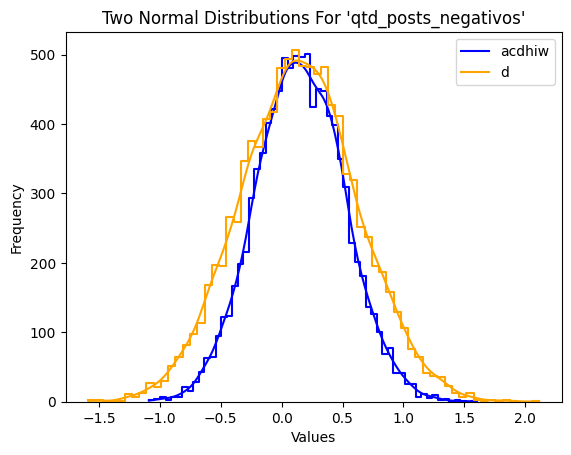

In [141]:
msf = metrics_stratified_filtered(users)

draw_distributions('acdhiw', 'd', 'qtd_posts_negativos', msf)

## Complex Networks

In [370]:
a1, a2, a3, b1, b2, b3, c1, c2, c3 = (1, 0, 0, 1, 0, 0, 1, 0, 0)

G_significants = create_graph_from_metric(users, metric=Metric.significants, a1=a1, a2=a2, a3=a3, b1=b1, b2=b2, b3=b3, c1=c1, c2=c2, c3=c3)

C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\1785055771.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  rel_emoticon3 = abs_emoticon / abs_mean_emoticon # "relative3" value for emoticon metric
C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\1785055771.py:58: RuntimeWarning: invalid value encountered in scalar multiply
  return a1*rel_negative1 + b1*rel_emoticon1 + c1*rel_neutral1 + a2*rel_negative2 + b2*rel_emoticon2 + c2*rel_neutral2 + a3*rel_negative3 + b3*rel_emoticon3 + c3*rel_neutral3
C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\1785055771.py:29: RuntimeWarning: invalid value encountered in scalar divide
  rel_negative3 = abs_negative / abs_mean_negative # "relative3" value for negative metric
C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\1785055771.py:45: RuntimeWarning: invalid value encountered in scalar divide
  rel_neutral3 = abs_neutral / abs_mean_neutral # "relative3" value for neutral metric
C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\

In [371]:
G_significants.edges.data("weight")

EdgeDataView([('10-acdhiw', '12-cdi', 1.109518500104498), ('10-acdhiw', '13-d', 0.570766722074406), ('10-acdhiw', '14-cd', 3.6612353207661714), ('10-acdhiw', '15-d', 11.816144822558217), ('10-acdhiw', '16-d', 4.839674263942661), ('10-acdhiw', '17-d', 3.1321112471953585), ('10-acdhiw', '19-di', 2.648656414962308), ('10-acdhiw', '21-d', 3.992946377784505), ('10-acdhiw', '26-cd', 6.922119012532351), ('10-acdhiw', '59-acdhiw', 2.0), ('10-acdhiw', '73-d', 17.92941167584667), ('10-acdhiw', '87-d', 39.02409464522011), ('10-acdhiw', '109-d', 3.422231757708478), ('10-acdhiw', '115-i', 0.511091303002339), ('10-acdhiw', '116-d', 1.9929463777845047), ('10-acdhiw', '122-d', 15.665241283454332), ('10-acdhiw', '123-d', 1.7075630167473017), ('10-acdhiw', '126-acdhiw', 14.0), ('10-acdhiw', '134-d', 14.799669003389269), ('10-acdhiw', '136-acdhiw', 39.0), ('10-acdhiw', '154-d', 2.8467278861581558), ('10-acdhiw', '161-acdhiw', 21.0), ('10-acdhiw', '162-d', 30.167736154114984), ('10-acdhiw', '167-d', 6.830

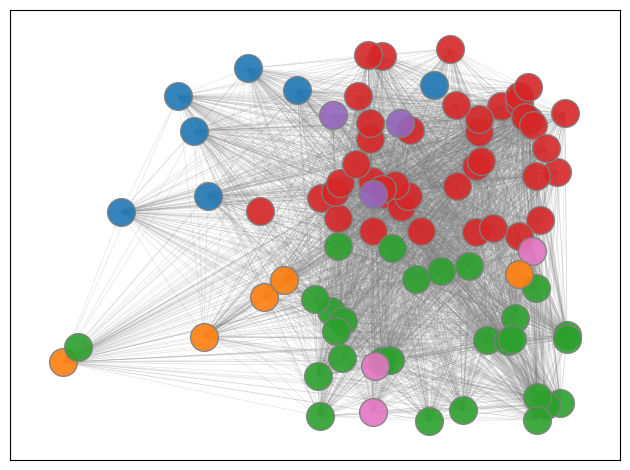

In [369]:
draw_graph(G_significants)

In [348]:
calc_modularity(G_significants)

0.08753158323776894

In [415]:
G = G_significants
partition_louvain = nx.community.louvain_communities(G_significants)

grouped = get_grouped_temperaments_from_partition(partition_louvain)

partition_louvain, grouped

([{'8-ad'},
  {'10-acdhiw',
   '1000-acdhiw',
   '1001-acdhiw',
   '1002-acdhiw',
   '1005-acdhiw',
   '1016-acdhiw',
   '1019-acdhiw',
   '1028-acdhiw',
   '1029-acdhiw',
   '1035-acdhiw',
   '1036-acdhiw',
   '126-acdhiw',
   '136-acdhiw',
   '161-acdhiw',
   '173-acdhiw',
   '204-acdhiw',
   '205-acdhiw',
   '210-acdhiw',
   '220-acdhiw',
   '236-acdhiw',
   '248-acdhiw',
   '256-acdhiw',
   '262-acdhiw',
   '266-acdhiw',
   '268-acdhiw',
   '272-acdhiw',
   '59-acdhiw'},
  {'1003-cdi',
   '1017-i',
   '1037-i',
   '115-i',
   '12-cdi',
   '14-cd',
   '172-cd',
   '19-di',
   '214-cd',
   '238-cdi',
   '242-di',
   '253-cd',
   '255-di',
   '26-cd',
   '263-i',
   '264-cd'},
  {'1004-d',
   '1006-d',
   '1008-d',
   '1010-d',
   '1013-d',
   '1014-d',
   '1015-d',
   '1021-d',
   '1022-d',
   '1023-d',
   '1025-d',
   '1030-d',
   '1031-d',
   '1032-d',
   '1034-d',
   '1038-d',
   '1040-d',
   '109-d',
   '116-d',
   '122-d',
   '123-d',
   '13-d',
   '134-d',
   '15-d',
   '154-d'

In [397]:
communities_labels = get_labels_for_grouped(grouped)
communities_labels

['ad', 'cd-di-i-cdi', 'acdhiw', 'd', 'hi', 'dh', 'c']

In [409]:
a1, a2, a3, b1, b2, b3, c1, c2, c3 = (1, 0, 0, 1, 0, 0, 1, 0, 0)
G_significants_louvain = create_graph_from_communities(users, partition_louvain, metric=Metric.significants, a1=a1, a2=a2, a3=a3, b1=b1, b2=b2, b3=b3, c1=c1, c2=c2, c3=c3)
# G_significants_louvain = create_community_graph(G_significants, partition)
G_significants_louvain

C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\1785055771.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  rel_emoticon3 = abs_emoticon / abs_mean_emoticon # "relative3" value for emoticon metric
C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\1785055771.py:58: RuntimeWarning: invalid value encountered in scalar multiply
  return a1*rel_negative1 + b1*rel_emoticon1 + c1*rel_neutral1 + a2*rel_negative2 + b2*rel_emoticon2 + c2*rel_neutral2 + a3*rel_negative3 + b3*rel_emoticon3 + c3*rel_neutral3
C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\1785055771.py:29: RuntimeWarning: invalid value encountered in scalar divide
  rel_negative3 = abs_negative / abs_mean_negative # "relative3" value for negative metric
C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\1785055771.py:45: RuntimeWarning: invalid value encountered in scalar divide
  rel_neutral3 = abs_neutral / abs_mean_neutral # "relative3" value for neutral metric
C:\Users\ph_ma\AppData\Local\Temp\ipykernel_5804\

In [410]:
G_significants_louvain.edges.data("weight")

EdgeDataView([('10-acdhiw', '59-acdhiw', 2.0), ('10-acdhiw', '126-acdhiw', 14.0), ('10-acdhiw', '136-acdhiw', 39.0), ('10-acdhiw', '161-acdhiw', 21.0), ('10-acdhiw', '173-acdhiw', 7.0), ('10-acdhiw', '204-acdhiw', 19.0), ('10-acdhiw', '205-acdhiw', 4.0), ('10-acdhiw', '210-acdhiw', 92.0), ('10-acdhiw', '220-acdhiw', 7.0), ('10-acdhiw', '236-acdhiw', 29.0), ('10-acdhiw', '248-acdhiw', 11.0), ('10-acdhiw', '256-acdhiw', 3.0), ('10-acdhiw', '262-acdhiw', 3.0), ('10-acdhiw', '266-acdhiw', 20.0), ('10-acdhiw', '268-acdhiw', 1.0), ('10-acdhiw', '272-acdhiw', 11.0), ('10-acdhiw', '1000-acdhiw', 2.0), ('10-acdhiw', '1001-acdhiw', 5.0), ('10-acdhiw', '1002-acdhiw', 15.0), ('10-acdhiw', '1005-acdhiw', 48.0), ('10-acdhiw', '1016-acdhiw', 39.0), ('10-acdhiw', '1019-acdhiw', 2.0), ('10-acdhiw', '1028-acdhiw', 1.0), ('10-acdhiw', '1029-acdhiw', 10.0), ('10-acdhiw', '1035-acdhiw', 1.0), ('10-acdhiw', '1036-acdhiw', 29.0), ('59-acdhiw', '126-acdhiw', 14.0), ('59-acdhiw', '136-acdhiw', 39.0), ('59-acdh

In [418]:
import itertools

combs = list(map(lambda x: len(list(itertools.combinations(x, 2))), partition_louvain))
soma_combs = sum(combs)
combs, soma_combs, len(list(G_significants_louvain.edges))

([0, 351, 120, 820, 0, 0, 0], 1291, 1271)

In [427]:
find_two = lambda G, x, y: list(filter(lambda e: x in e[0] and y in e[1] or y in e[0] and x in e[1], G.edges.data("weight")))

In [428]:
find_two(G_significants, '19-di', '1017-i')

[('19-di', '1017-i', 8.972449359523921)]

In [429]:
communities = infer_communities_from_node_data(G_significants_louvain, target="community")
communities

{'1', '2', '3'}

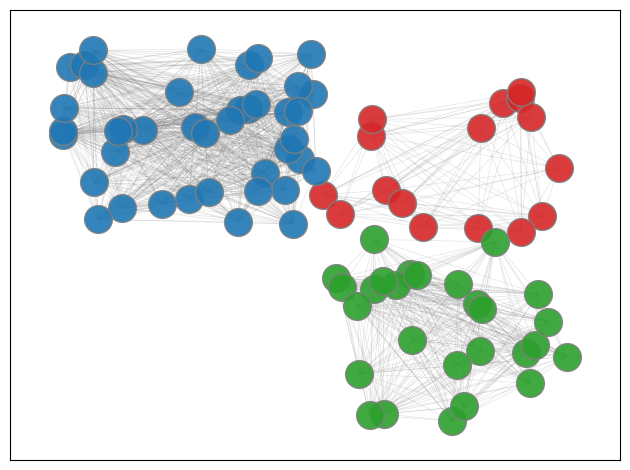

In [431]:
draw_graph(G_significants_louvain,
            color_map={'1': 'tab:red',
                          '2': 'tab:green',
                          '3': 'tab:blue'},
            max_dir=3,
            color_map_dir={'1': (1,1),
                              '2': (1,-1),
                              '3': (-1,1)},
            options = {"edgecolors": "tab:gray", "node_size": 400, "alpha": 0.9},
            pos_override=None, target="community")

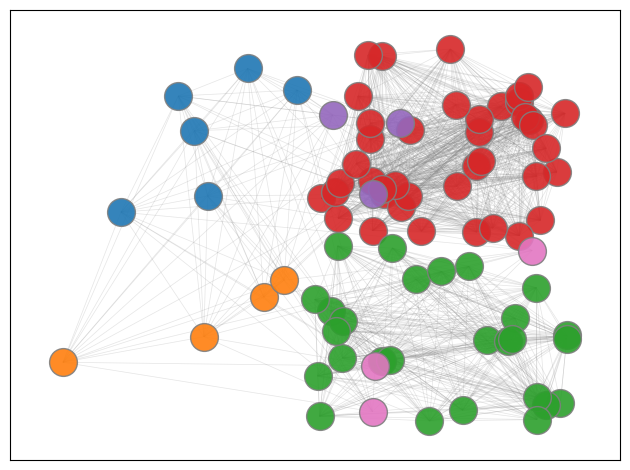

In [432]:
draw_graph(G_significants_louvain)

In [433]:
communities = infer_communities_from_node_data(G_significants_louvain, target="temperamento")
communities

{'acdhiw', 'cd', 'cdi', 'd', 'di', 'i'}

In [434]:
calc_modularity(G_significants_louvain, communities)

0.43686301607553857

In [435]:
calc_modularity(G_significants_louvain)

0.43686301607553857

In [ ]:
# partitions_girvan_newman = nx.community.girvan_newman(G_significants)
# for partition in partitions:
#     print(partition)